In [1]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import pingouin as pg
from venn import venn
import matplotlib.pyplot as plt

In [2]:
hilic_pos = pd.read_csv('../raw_data/ST000923_AN001513_HILIC_POS.txt', '\t')
hilic_neg = pd.read_csv('../raw_data/ST000923_AN001514_HILIC_NEG.txt', '\t')
c18 = pd.read_csv('../raw_data/ST000923_AN001515_C18_NEG.txt', '\t')
c8 = pd.read_csv('../raw_data/ST000923_AN001516_C8_POS.txt', '\t')
sample_annotation = pd.read_csv('../raw_data/sample_annotation.csv', '\t')
selected_metabolites_hilic_pos = pd.read_excel('../raw_data/2nd_Round_Research_metabolites_list.xlsx',sheet_name=3)
selected_metabolites_hilic_neg = pd.read_excel('../raw_data/2nd_Round_Research_metabolites_list.xlsx',sheet_name=2)
selected_metabolites_c18 = pd.read_excel('../raw_data/2nd_Round_Research_metabolites_list.xlsx',sheet_name=0)
selected_metabolites_c8 = pd.read_excel('../raw_data/2nd_Round_Research_metabolites_list.xlsx',sheet_name=1)

In [3]:
hilic_pos.columns = hilic_pos.columns.str.replace(' ', '')
hilic_neg.columns = hilic_pos.columns.str.replace(' ', '')
c18.columns = hilic_pos.columns.str.replace(' ', '')
c8.columns = hilic_pos.columns.str.replace(' ', '')

hilic_pos = hilic_pos.set_index('metabolite_name').fillna(0)
hilic_neg = hilic_neg.set_index('metabolite_name').fillna(0)
c18 = c18.set_index('metabolite_name').fillna(0)
c8 = c8.set_index('metabolite_name').fillna(0)

sample_annotation_dict = dict(zip(sample_annotation.Subject, sample_annotation.Diagnosis))

lut = dict(zip(sample_annotation['Diagnosis'].unique(), "rbg"))
sample_colors = sample_annotation['Diagnosis'].map(lut)

In [4]:
def generate_clustermap(dataframe,colors):
    x = dataframe.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df.set_index(dataframe.index.values)
    sns.clustermap(df.fillna(0), cmap="mako",col_colors = colors)
    plt.savefig("../images/clustermap.svg", format="svg")
    

/home/cj/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


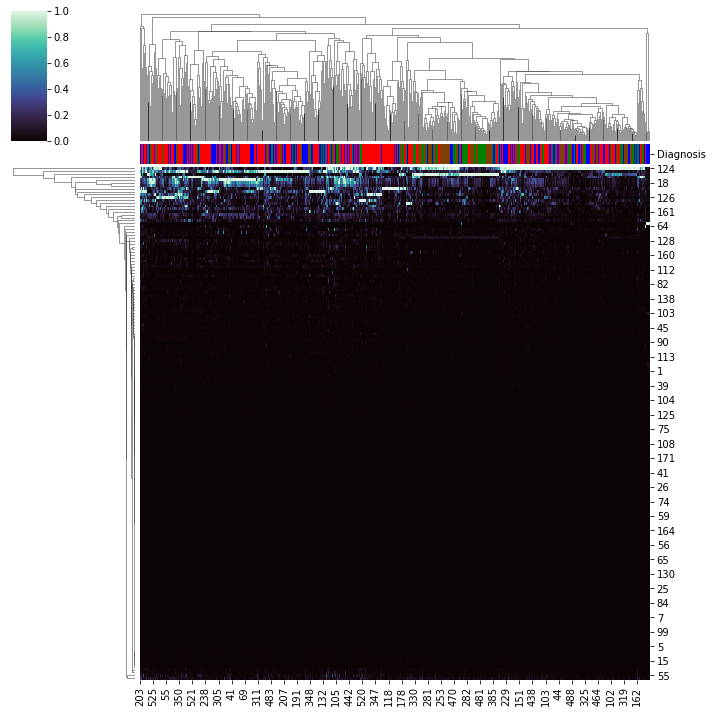

In [5]:
generate_clustermap(hilic_pos, sample_colors)

In [6]:
def generate_pval(dataframe):
    y = dataframe.T
    condition = [sample_annotation_dict[x] for x in list(y.index.values)]
    y['condition'] = condition
    p = pd.melt(y, id_vars=['condition'])
    
    my_list = []
    for metabolite in p['metabolite_name'].unique():
        sub_df = p[p["metabolite_name"] == metabolite]
        posthoc = pg.anova(data=sub_df, dv='value', between='condition', detailed = True)
        my_list.append([metabolite,posthoc.iloc[0]['p-unc']])
    
    df = pd.DataFrame(my_list, columns = ['metabolite', 'p_val']) 
    df = df[df['p_val'] <= .05]
    return df

In [7]:
filtered_hilic_pos = hilic_pos.loc[list(generate_pval(hilic_pos)['metabolite'])]

/home/cj/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


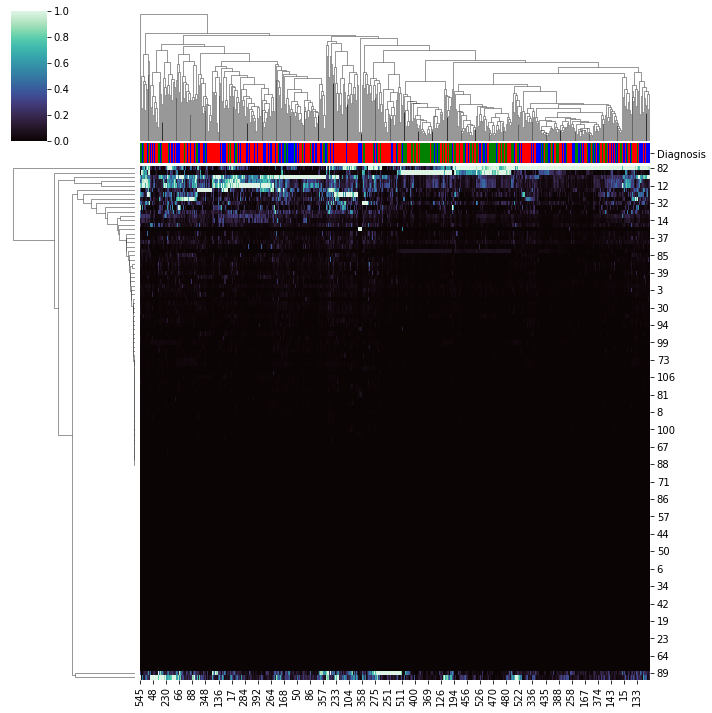

In [8]:
generate_clustermap(filtered_hilic_pos,sample_colors)

In [9]:
def generate_venn(selected_metabolite_df):
    venn_dict = {
        '0% Imputation': set(selected_metabolite_df.iloc[:,1].dropna().values),
        '60% Imputation': set(selected_metabolite_df.iloc[:,2].dropna().values),
        '70% Imputation': set(selected_metabolite_df.iloc[:,3].dropna().values),
        '80% Imputation': set(selected_metabolite_df.iloc[:,4].dropna().values),
        '100% Imputation': set(selected_metabolite_df.iloc[:,5].dropna().values)
                 }
    
    venn(venn_dict)
    plt.savefig("../images/venn.svg", format="svg")    

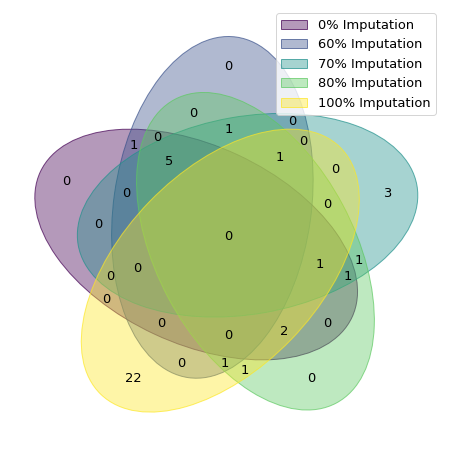

In [10]:
generate_venn(selected_metabolites_hilic_pos)

In [11]:
def generate_boxplot(selected_metabolite_df,full_df, remove_variable = [], pval_df = []):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    imp1 = set(selected_metabolite_df.iloc[:,1].dropna().values)
    imp2 = set(selected_metabolite_df.iloc[:,2].dropna().values)
    imp3 = set(selected_metabolite_df.iloc[:,3].dropna().values)
    imp4 = set(selected_metabolite_df.iloc[:,4].dropna().values)
    imp5 = set(selected_metabolite_df.iloc[:,5].dropna().values)
    union = set.union(imp1,imp2,imp3,imp4,imp5)
    if len(remove_variable) > 0:
        for item in remove_variable:
            union.remove(item)
    if len(pval_df) > 0:
        union = union.difference(set(pval_df.index.values))
        print(union)
    x = full_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df = df.set_index(full_df.index.values)
    df.columns = full_df.columns
    df = df.loc[union]
    df = df.T     
    df['condition'] = list(sample_annotation['Diagnosis'])
    melted_df = pd.melt(df, id_vars=['condition'])
    ax = sns.boxplot(x="variable", y="value",hue = 'condition', data=melted_df, showfliers = False)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.savefig("../images/boxplot.svg", format="svg") 

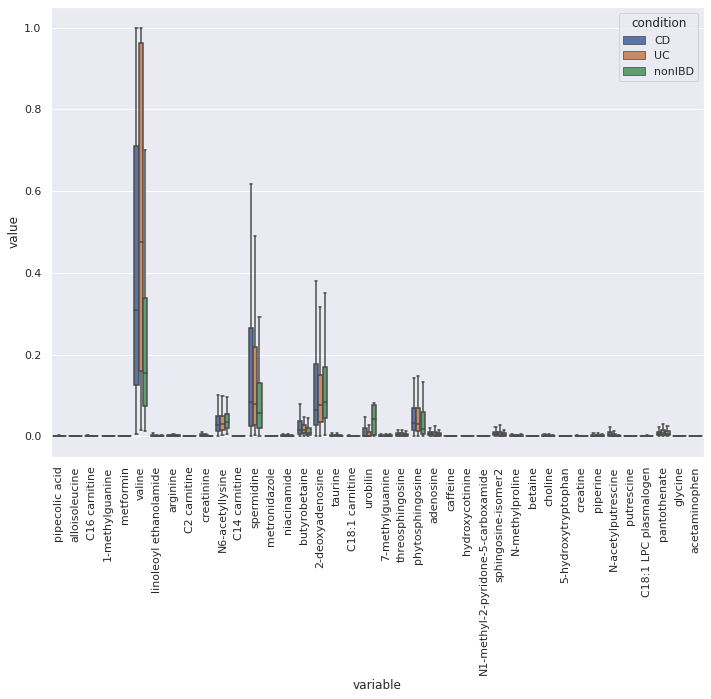

In [12]:
generate_boxplot(selected_metabolites_hilic_pos,hilic_pos) 

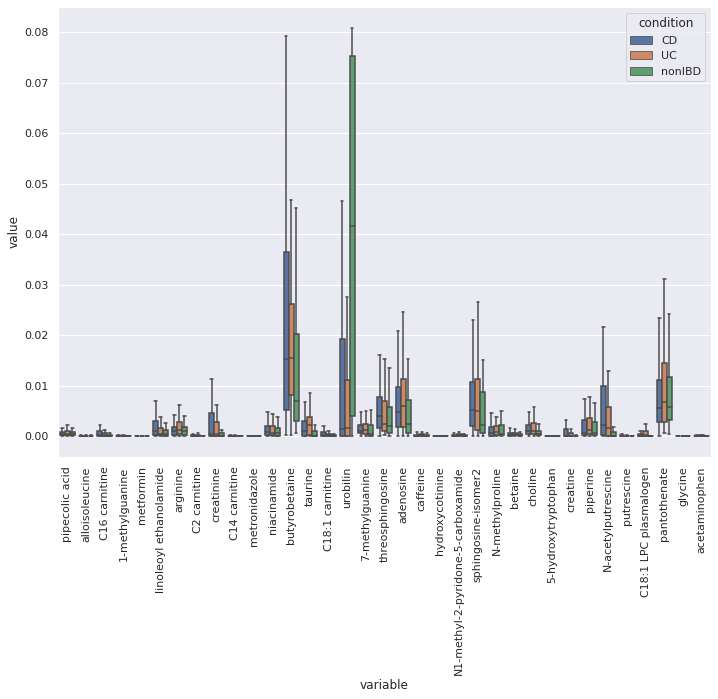

In [13]:
generate_boxplot(selected_metabolites_hilic_pos,hilic_pos, ['valine','spermidine','2-deoxyadenosine','N6-acetyllysine','phytosphingosine'])    


{'5-hydroxytryptophan', 'alloisoleucine', 'metronidazole', 'piperine', 'niacinamide', 'N-methylproline', 'C2 carnitine', 'acetaminophen'}


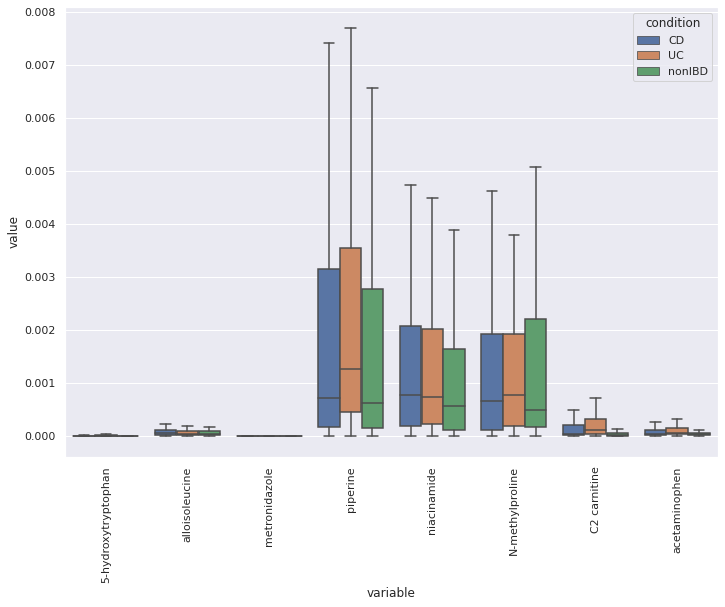

In [14]:
generate_boxplot(selected_metabolites_hilic_pos,hilic_pos, pval_df=filtered_hilic_pos) 

In [19]:
def generate_venn_overlap_w_filtered(selected_metabolite_df, pvalue_df, all_df):
    for value in range(1,6):
        venn_dict = {
            'Knockoff': set(selected_metabolite_df.iloc[:,value].dropna().values),
            'p-Value Cutoff': set(pvalue_df.index.values),
            'All Metabolites': set(all_df.index.values)
                     }
#        print(set(selected_metabolite_df.iloc[:,value].dropna().values).difference(set(pvalue_df.index.values)))
        venn(venn_dict) 
        plt.savefig("../images/boxplot.svg", format="svg") 

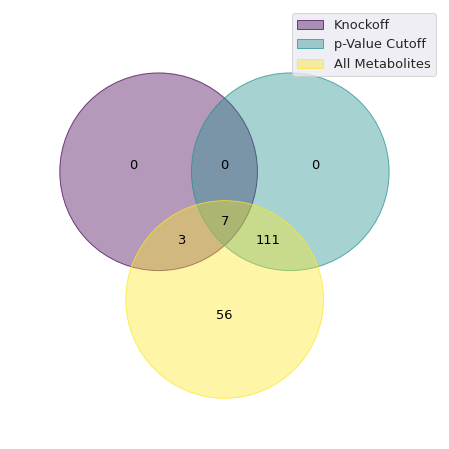

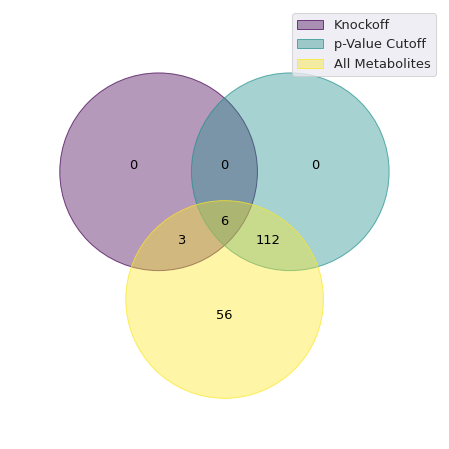

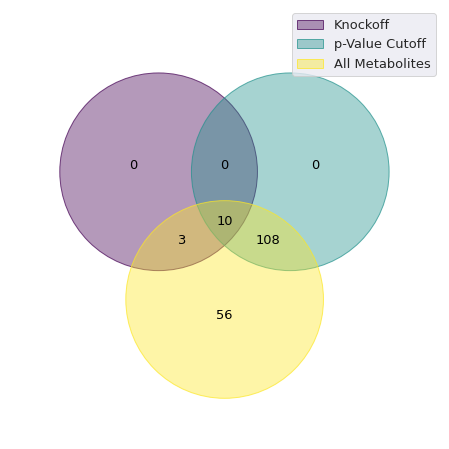

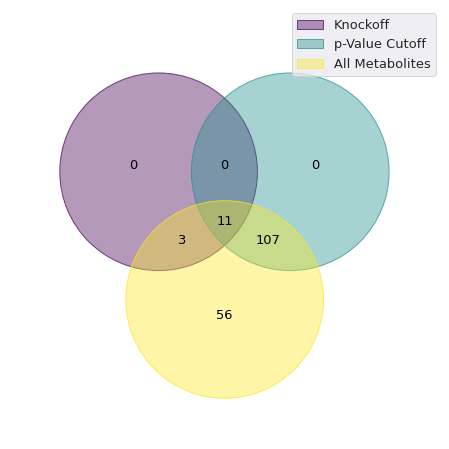

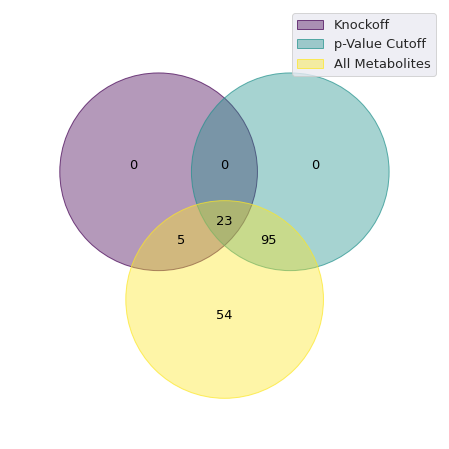

In [18]:
generate_venn_overlap_w_filtered(selected_metabolites_hilic_pos, filtered_hilic_pos, hilic_pos)